<a href="https://colab.research.google.com/github/hnm15/DS703/blob/main/Homework_03_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 03: Learning Curves and Training Workflow

## Due: Midnight on September 21 (with 2-hour grace period)

**Points:** 85

In this assignment, you will learn how to design, train, and evaluate neural networks by systematically exploring key design choices. Your focus will be on developing an effective **training workflow** — using learning curves and validation metrics to guide your decisions.

We'll use the **Forest Cover Type (Covertype) dataset,** which has ~581k tabular records with 54 cartographic/topographic features (elevation, aspect, slope, soil and wilderness indicators) used to predict one of seven tree cover types in Colorado’s Roosevelt National Forest. It’s a large, mildly imbalanced multi-class benchmark commonly used to compare classical ML and deep learning on tabular data.

We will start with a **baseline model** (two hidden layers of sizes 64 and 32), and gradually introduce and tune different hyperparameters. Each of the first five problems considers  different hyperparameter choices, and the last problem is your chance to use what you have learned to design your best model:

1. **Activation function** – Compare ReLU, sigmoid, and tanh to see which provides the best accuracy.
2. **Learning rate** – Explore a range of learning rates and identify which balances convergence speed and stability.
3. **Dropout** – Investigate how different dropout rates reduce overfitting and where they are most effective.
4. **L2 regularization** – Experiment with weight penalties to encourage simpler models and avoid memorization.
5. **Dropout + L2** – Combine both regularization techniques and study their interaction.
6. **Best model design** – Use all your insights to build and train your strongest model, with the option to try **learning rate scheduling** for further improvement.

Throughout, you will use **early stopping** to select the model at the epoch of **minimum validation loss**, and you will report the **validation accuracy** of that selected model as the primary measure of performance.

By the end of this homework, you will not only understand how different hyperparameters affect training and generalization, but also gain hands-on practice in building a disciplined workflow for model development.

There are 10 graded problems, worth 8 points each, with 5 points for free if you complete the homework.

In [80]:
# Useful imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import time
import os

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight

import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Input,Dropout
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.schedules import ExponentialDecay


from tensorflow.keras.datasets import fashion_mnist

# utility code

random_seed = 42

def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppresses INFO and WARNING messages


In [81]:
# Utility function to plot learning curves and keep track of all results

# Call `print_results()` to see listing of all results logged so far


def plot_learning_curves(hist, title, verbose=True):

    val_losses = hist.history['val_loss']
    min_val_loss = min(val_losses)
    min_val_epoch = val_losses.index(min_val_loss)
    val_acc_at_min_loss = hist.history['val_accuracy'][min_val_epoch]

    epochs = range(1, len(val_losses) + 1)  # epoch numbers starting at 1

    fig, axs = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

    # --- Loss Plot ---
    axs[0].plot(epochs, hist.history['loss'], label='train loss')
    axs[0].plot(epochs, hist.history['val_loss'], label='val loss')
    axs[0].scatter(min_val_epoch + 1, min_val_loss, color='red', marker='x', s=50, label='min val loss')
    axs[0].set_title(f'{title} - Categorical Cross-Entropy Loss')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[0].grid(True)

    # --- Accuracy Plot ---
    axs[1].plot(epochs, hist.history['accuracy'], label='train acc')
    axs[1].plot(epochs, hist.history['val_accuracy'], label='val acc')
    axs[1].scatter(min_val_epoch + 1, val_acc_at_min_loss, color='red', marker='x', s=50, label='acc @ min val loss')
    axs[1].set_title(f'{title} - Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()
    axs[1].grid(True)
    axs[1].set_ylim(0, 1.05)

    plt.tight_layout()
    plt.show()

    if verbose:
        print(f"Final Training Loss:            {hist.history['loss'][-1]:.4f}")
        print(f"Final Training Accuracy:        {hist.history['accuracy'][-1]:.4f}")
        print(f"Final Validation Loss:          {hist.history['val_loss'][-1]:.4f}")
        print(f"Final Validation Accuracy:      {hist.history['val_accuracy'][-1]:.4f}")
        print(f"Minimum Validation Loss:        {min_val_loss:.4f} (Epoch {min_val_epoch + 1})")
        print(f"Validation Accuracy @ Min Loss: {val_acc_at_min_loss:.4f}")

    results[title] = (val_acc_at_min_loss,{min_val_epoch + 1})

results = {}

**The plotting function will record the validation accuracy for each experiment, using the plot title as key. The next function will print these out (see the last cell in the notebook).**


In order to see all results, you must give a different plot title to each experiment.

In [82]:
def print_results():
    for title, (acc, ep) in sorted(results.items(),
                                   key=lambda kv: kv[1][0],   # kv[1] is (acc, epoch); [0] is acc
                                   reverse=True
                                  ):
        print(f"{title:<40}\t{acc:.4f}")

### Wrapper to train, display results, and run test set

We assume multi-class classification, and allow setting various parameters for training.

In [83]:
# Uses globals X_train,y_train,X_val,y_val

def train_and_test(model,
                   epochs        = 500,                   # Just needs to be bigger than early stop point
                   lr_schedule   = 0.001,                 # Adam default / 10 seems to work well for this dataset
                   optimizer     = "Adam",
                   title         = "Learning Curves",
                   batch_size    = 64,                     # experiments confirmed this was optimal with other parameters at default
                   use_early_stopping = True,
                   patience      = 10,
                   min_delta     = 0.0001,
                   callbacks     = [],                     # for extra callbacks other than early stopping
                   verbose       = 0,
                   return_history = False
                  ):

    print(f"\n{title}\n")


    if optimizer == "Adam":
        opt = Adam(learning_rate=lr_schedule)
    else:
        opt = optimizer

    #Compiling the model
    model.compile(optimizer=opt,
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"]
                 )

    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=patience,
        min_delta=min_delta,
        restore_best_weights=True,               # this will mean that the model which produced the smallest validation loss will be returned
        verbose=verbose
    )


    if use_early_stopping:
        cbs=[early_stop] + callbacks
    else:
        cbs=callbacks

    # start timer
    start = time.time()

    # Fit the model with early stopping
    history = model.fit(X_train, y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(X_val, y_val),       # must use stratified validation set
                        callbacks=cbs,
                        verbose=verbose
                       )

    if use_early_stopping:
        best_epoch = early_stop.best_epoch
        best_acc   = history.history['val_accuracy'][best_epoch]
    else:
        best_epoch = np.argmax(history.history['val_accuracy'])
        best_acc   = history.history['val_accuracy'][best_epoch]

    # Plot training history
    plot_learning_curves(history, title=title)

    # Evaluate on test data
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

    print(f"\nTest Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")

    print(f"\nValidation-Test Gap (accuracy): {abs(best_acc - test_accuracy):.6f}")

    # Record end time and print execution time
    end = time.time()
    print(f"\nExecution Time: " + format_hms(end-start))

    if return_history:
        return history

### Load the dataset and extract a stratified subset

This datasest is rather large (581,012 samples) and unbalanced, but for the purposes of this homework, we use a much smaller set, and select samples so that it is balanced.

In [84]:
# complete cell: load, balance, split into X_train/y_train/x_val/y_val/X_test/y_test, and standardize
from collections import Counter
from sklearn.datasets import fetch_covtype
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# 1) load
x, y = fetch_covtype(return_X_y=True)  # y in {1..7}
print("full dataset shape:", x.shape)

# 2) build a perfectly balanced subset across 7 classes (no replacement)
classes, counts = np.unique(y, return_counts=True)
# min_count = counts.min()  # size of rarest class                         # You can modify this parameter to increase the size of the dataset, but above
min_count = 1000                                                           # counts.min() you'll produce an unbalanced set.


rng = np.random.default_rng(42)

idx_list = []
for c in classes:
    c_idx = np.where(y == c)[0]
    chosen = rng.choice(c_idx, size=min_count, replace=False)
    idx_list.append(chosen)

idx_bal = np.concatenate(idx_list)
rng.shuffle(idx_bal)

X_sub = x[idx_bal]
y_sub = y[idx_bal] - 1  # relabel to {0..6} for keras
print("balanced subset shape:", X_sub.shape, "class counts:", dict(Counter(y_sub)))

# 3) stratified 60/20/20 split (train/val/test)
test_size = 0.20
val_size = 0.20  # of the whole dataset

X_trainval, X_test, y_trainval, y_test = train_test_split(
    X_sub, y_sub, test_size=test_size, random_state=random_seed, stratify=y_sub
)
val_size_rel = val_size / (1.0 - test_size)  # e.g., 0.20 / 0.80 = 0.25

X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=val_size_rel, random_state=random_seed, stratify=y_trainval
)

# 4) standardize using train-only stats (float32 for tensorflow friendliness)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train).astype(np.float32)
X_val   = scaler.transform(X_val).astype(np.float32)
X_test  = scaler.transform(X_test).astype(np.float32)

# 5) quick sanity checks
def show_counts(name, y_arr):
    c = Counter(y_arr)
    total = sum(c.values())
    print(f"{name}: total={total}, per-class={dict(c)}")

print("shapes:", "X_train", X_train.shape, "X_val", X_val.shape, "X_test", X_test.shape)
show_counts("train", y_train)
show_counts("val  ", y_val)
show_counts("test ", y_test)

# you now have: X_train, y_train, X_val, y_val, X_test, y_test

# Looks like integer encoded multi-class, let's check and define the global n_classes

labels = np.unique(y_train)

n_classes = len(labels)

print("class labels:",labels)


full dataset shape: (581012, 54)
balanced subset shape: (7000, 54) class counts: {np.int32(2): 1000, np.int32(0): 1000, np.int32(4): 1000, np.int32(5): 1000, np.int32(1): 1000, np.int32(3): 1000, np.int32(6): 1000}
shapes: X_train (4200, 54) X_val (1400, 54) X_test (1400, 54)
train: total=4200, per-class={np.int32(2): 600, np.int32(1): 600, np.int32(0): 600, np.int32(3): 600, np.int32(5): 600, np.int32(4): 600, np.int32(6): 600}
val  : total=1400, per-class={np.int32(1): 200, np.int32(6): 200, np.int32(5): 200, np.int32(4): 200, np.int32(3): 200, np.int32(2): 200, np.int32(0): 200}
test : total=1400, per-class={np.int32(0): 200, np.int32(6): 200, np.int32(2): 200, np.int32(3): 200, np.int32(4): 200, np.int32(5): 200, np.int32(1): 200}
class labels: [0 1 2 3 4 5 6]


## Prelude: Defining a model builder

In order to facilitate our experimentation, we'll write a function which builds models according to specifications:

- How many layers
- How wide each layer is
- How much dropout in each layer
- How much L2 Regularization in each layer

This is a fairly standard practice in ML, since the structure of simple models is fairly predictable and can be specified by a few hyperparameters.

In [85]:
# This function will build a multi-class classifier with dropout and L2 regularization.
# You must specify the number of input features, the number of classes, and a list of layer hyperparameters
# in the form  [ ...., (width, activation function, L2 lambda, dropout rate), .... ]

# Note that when adding dropout, this appears as a separate layer, but it has no parameters to be trained.

def build_model(n_inputs,layer_list,n_classes):
    layers = [ Input(shape=(n_inputs,)) ]
    for (width,act,l2_lambda,dropout_rate) in layer_list:
        layers.append( Dense(width, activation=act, kernel_regularizer=regularizers.l2(l2_lambda)) )
        if dropout_rate > 0:
            layers.append( Dropout(dropout_rate) )
    layers.append( Dense(n_classes, activation='softmax') )
    return models.Sequential( layers )


**Example: To build the following model:**

In [86]:
model = models.Sequential(
   [
    Input(shape=(X_train.shape[1],)),
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.0)),              # 0.0 means no regularization applied; no dropout, so no Dropout layer necessary
    Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.3),
    Dense(n_classes, activation='softmax')
   ]
)

model.summary()

Model: "sequential_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_90 (Dense)                │ (None, 64)             │         3,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_91 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_92 (Dense)                │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,831 (22.78 KB)

 Trainable params: 5,831 (22.78 KB)

 Non-trainable params: 0 (0.00 B)

**We call `build_model` as shown here:**

In [87]:
build_model(X_train.shape[1], [ (64,'relu',0.0,0.0), (32,'relu',0.001,0.3)], n_classes).summary()

Model: "sequential_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_93 (Dense)                │ (None, 64)             │         3,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_94 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_95 (Dense)                │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,831 (22.78 KB)

 Trainable params: 5,831 (22.78 KB)

 Non-trainable params: 0 (0.00 B)

-------------------



### Baseline Model Architecture

**Problems 1–5 will use the following baseline model structure,** implemented with the provided `build_model` function and trained using `train_and_test`:

```
input → 64 → 32 → output
```

* Two hidden layers of widths 64 and 32.
* Activation function, dropout rate, and L2 regularization term (λ) will vary as specified in each problem.
* **Early stopping** is always applied to select the model at the epoch of **minimum validation loss**.
* We will report the **validation accuracy** of the selected model as the primary metric.


### Problem One: Which Activation Function?

In this problem, you will train the **baseline neural network** and investigate which activation function produces the best performance. The model you create will be the one saved by **early stopping** — that is, the epoch where validation loss is minimized.

**Steps to follow:**

* Use the provided functions `train_and_test` and `build_model` to create a model named **`model_baseline`**.
* Train and evaluate this model using each of the following activation functions in the hidden layers:

  * `relu`
  * `sigmoid`
  * `tanh`
* Identify which activation function produces the **best validation accuracy** at the epoch of **minimum validation loss**.
* Answer the graded questions.



Baseline with relu



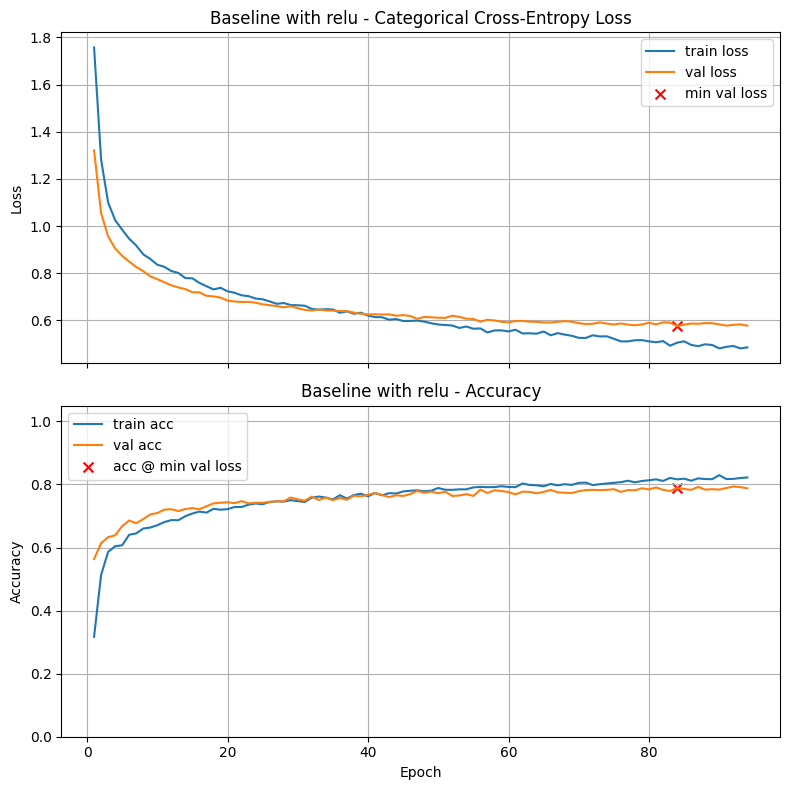

Final Training Loss:            0.4858
Final Training Accuracy:        0.8221
Final Validation Loss:          0.5781
Final Validation Accuracy:      0.7879
Minimum Validation Loss:        0.5761 (Epoch 84)
Validation Accuracy @ Min Loss: 0.7886

Test Loss: 0.6117
Test Accuracy: 0.7729

Validation-Test Gap (accuracy): 0.015714

Execution Time: 00:00:31



Baseline with sigmoid



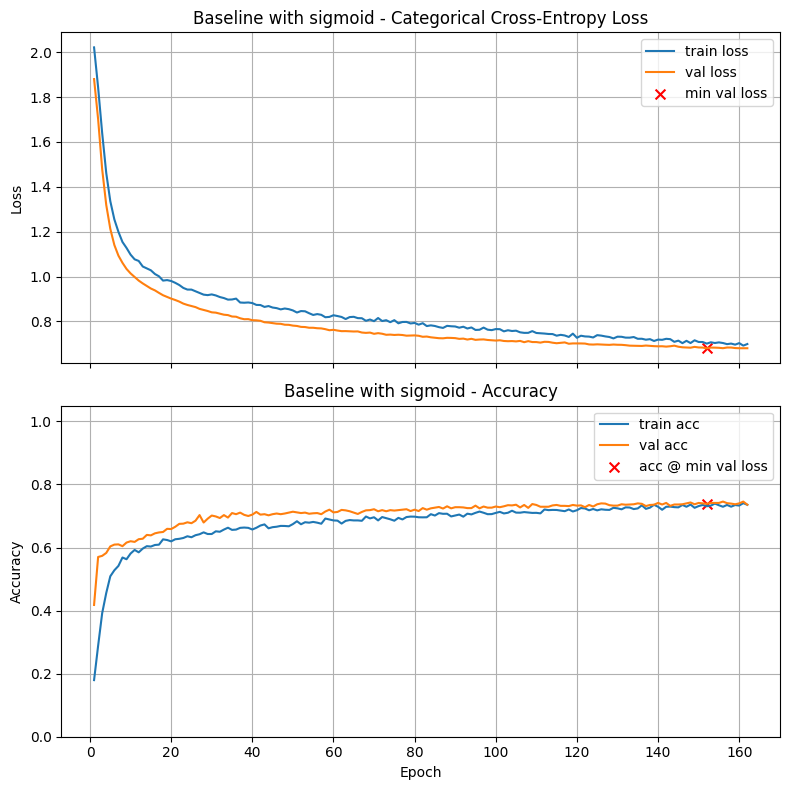

Final Training Loss:            0.6992
Final Training Accuracy:        0.7355
Final Validation Loss:          0.6805
Final Validation Accuracy:      0.7357
Minimum Validation Loss:        0.6798 (Epoch 152)
Validation Accuracy @ Min Loss: 0.7386

Test Loss: 0.7150
Test Accuracy: 0.7293

Validation-Test Gap (accuracy): 0.009286

Execution Time: 00:00:54



Baseline with tanh



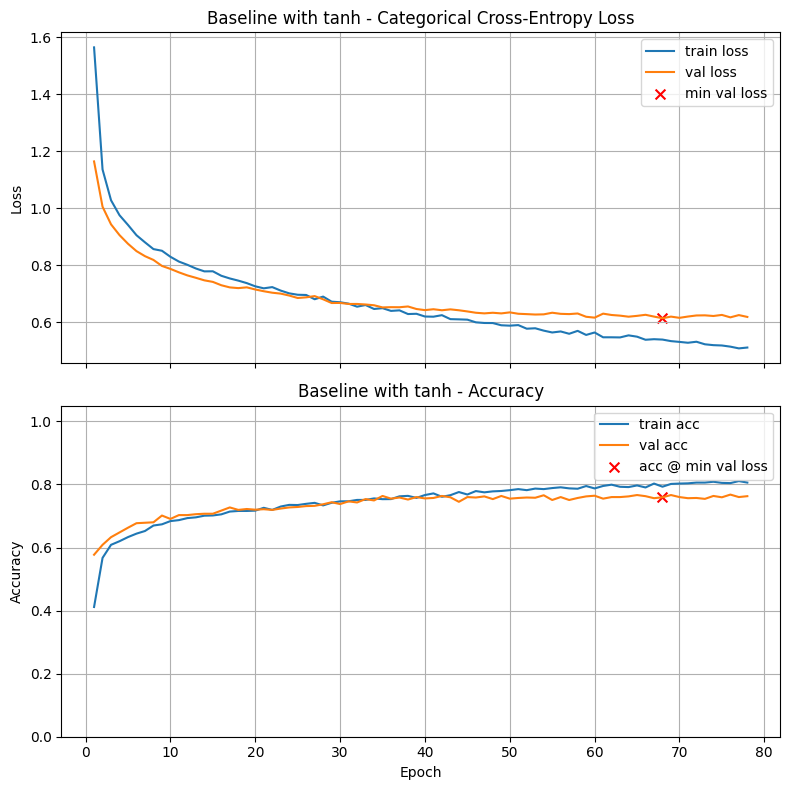

Final Training Loss:            0.5108
Final Training Accuracy:        0.8060
Final Validation Loss:          0.6181
Final Validation Accuracy:      0.7629
Minimum Validation Loss:        0.6135 (Epoch 68)
Validation Accuracy @ Min Loss: 0.7593

Test Loss: 0.6360
Test Accuracy: 0.7514

Validation-Test Gap (accuracy): 0.007857

Execution Time: 00:00:27



Summary of results:
Baseline with relu                      	0.7886
Baseline with tanh                      	0.7593
Baseline with sigmoid                   	0.7386


In [88]:
# Your code here. Add as many cells as you need.

def build_model_baseline(act="relu"):
    return build_model(
        n_inputs=X_train.shape[1],
        layer_list=[
            (64, act, 0.0, 0.0),
            (32, act, 0.001, 0.3),
        ],
        n_classes=n_classes
    )

activations = ["relu", "sigmoid", "tanh"]

for act in activations:
    model_baseline = build_model_baseline(act=act)
    history = train_and_test(
        model_baseline,
        title=f"Baseline with {act}",
        epochs=200,
        batch_size=64,
        lr_schedule=0.001,
        optimizer="Adam",
        patience=10,
        min_delta=0.0001,
        verbose=0,
        return_history=True
    )
    print("\n" + "="*60 + "\n")

print("\nSummary of results:")
print_results()



### Graded Questions

In [89]:
# Set a1a to the activation function which provided the best validation accuracy at the epoch of minimum validation loss

a1a = 0             # Replace with integer 0 (relu), 1 (sigmoid), or 2 (tanh)

In [90]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a1a = {a1a}')


a1a = 0


In [115]:
# Set a1b to the validation accuracy found by this best activation function

a1b = 0.7886             # Replace 0.0 with your answer

In [116]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a1b = {a1b:.4f}')

a1b = 0.7886


### Problem Two: Finding the Right Learning Rate

In this problem, you will continue working with the **baseline model** and determine which learning rate produces the best performance. As before, the model you evaluate should be the one saved by **early stopping** — the epoch where validation loss is minimized.

**Steps to follow:**

* Build and train the **baseline model** using the **activation function identified in Problem One**.

* Train and evaluate this model using each of the following learning rates:

  ```
      [1e-3, 5e-4, 1e-4, 5e-5, 1e-5]
  ```

* Identify which learning rate produces the **best validation accuracy** at the epoch of **minimum validation loss**, within a maximum of **500 epochs**.

* Answer the graded questions.


**Note: Smaller learning rates will generally take more epochs to reach the optimal point, so some of these will not engage early stopping, but run the full 500 epochs.**



Training with learning rate: 0.001

Baseline LR=0.001



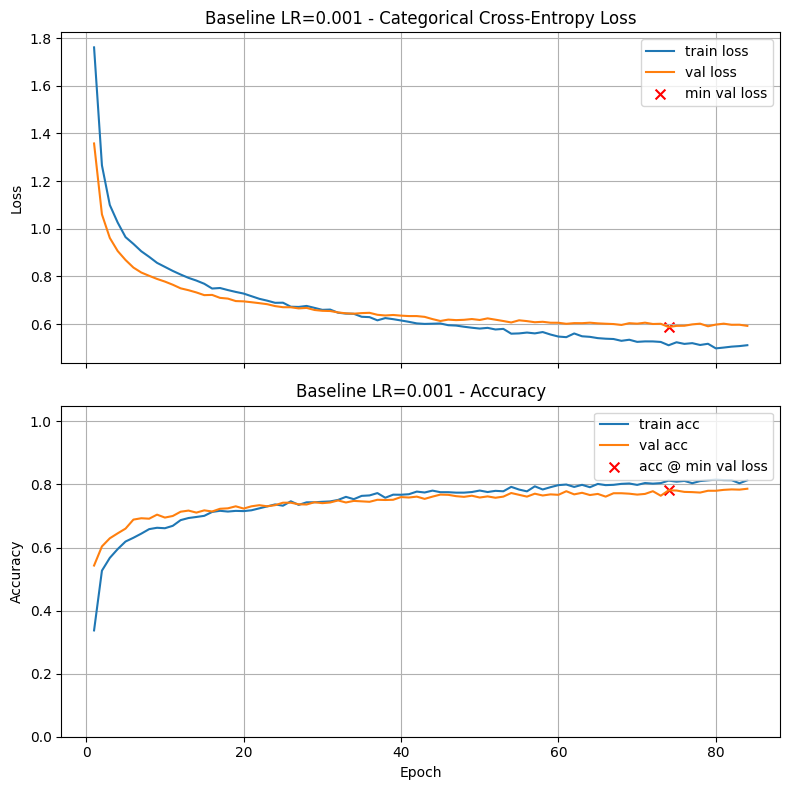

Final Training Loss:            0.5114
Final Training Accuracy:        0.8133
Final Validation Loss:          0.5925
Final Validation Accuracy:      0.7864
Minimum Validation Loss:        0.5877 (Epoch 74)
Validation Accuracy @ Min Loss: 0.7814

Test Loss: 0.6277
Test Accuracy: 0.7643

Validation-Test Gap (accuracy): 0.017143

Execution Time: 00:00:28



Training with learning rate: 0.0005

Baseline LR=0.0005



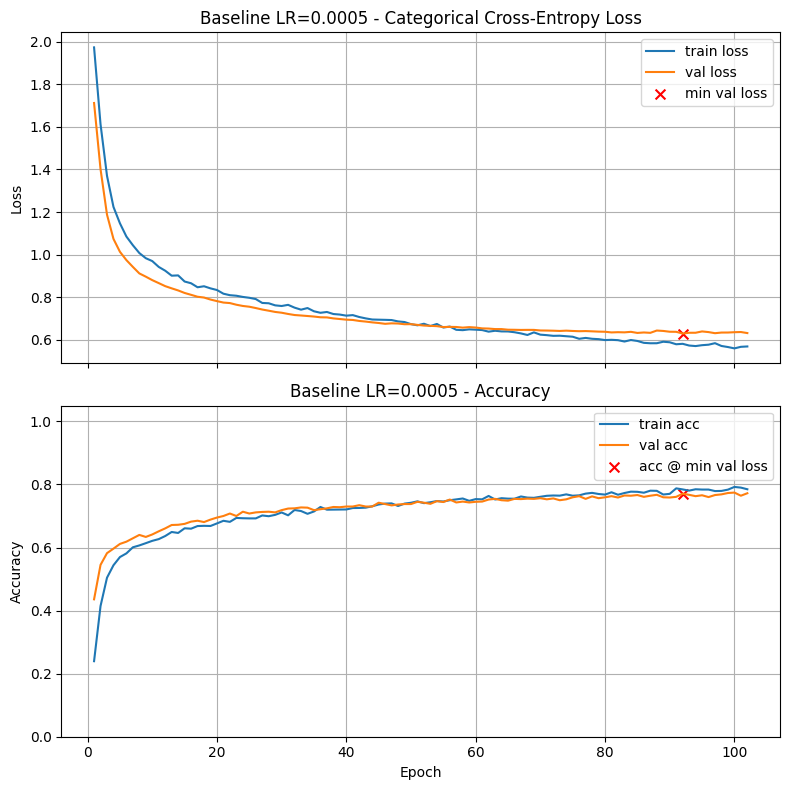

Final Training Loss:            0.5683
Final Training Accuracy:        0.7848
Final Validation Loss:          0.6312
Final Validation Accuracy:      0.7721
Minimum Validation Loss:        0.6290 (Epoch 92)
Validation Accuracy @ Min Loss: 0.7707

Test Loss: 0.6643
Test Accuracy: 0.7514

Validation-Test Gap (accuracy): 0.019286

Execution Time: 00:00:34



Training with learning rate: 0.0001

Baseline LR=0.0001



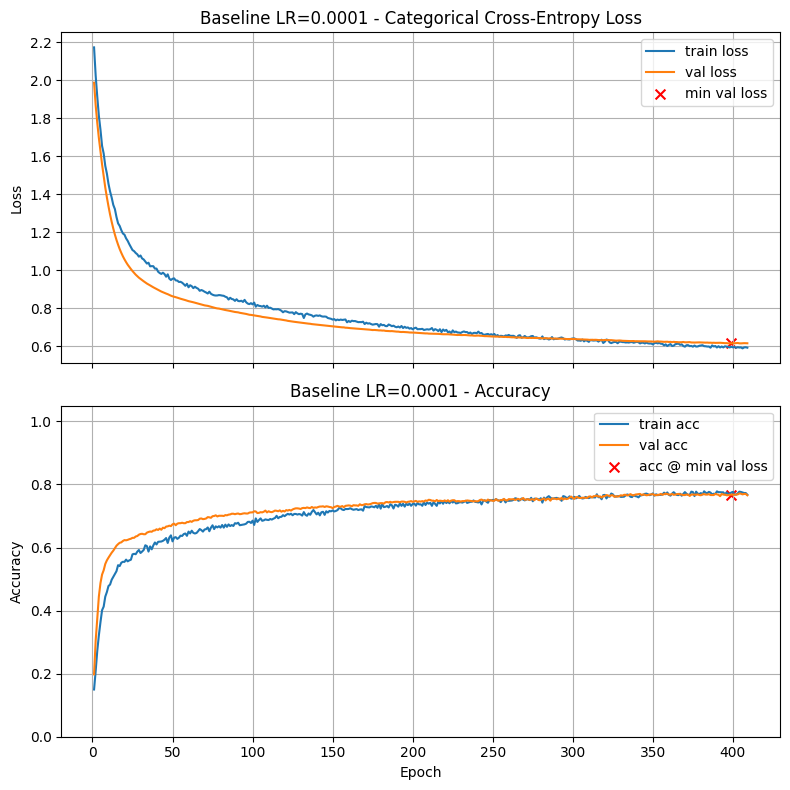

Final Training Loss:            0.5936
Final Training Accuracy:        0.7674
Final Validation Loss:          0.6168
Final Validation Accuracy:      0.7657
Minimum Validation Loss:        0.6162 (Epoch 399)
Validation Accuracy @ Min Loss: 0.7679

Test Loss: 0.6488
Test Accuracy: 0.7521

Validation-Test Gap (accuracy): 0.015714

Execution Time: 00:02:10



Training with learning rate: 5e-05

Baseline LR=5e-05



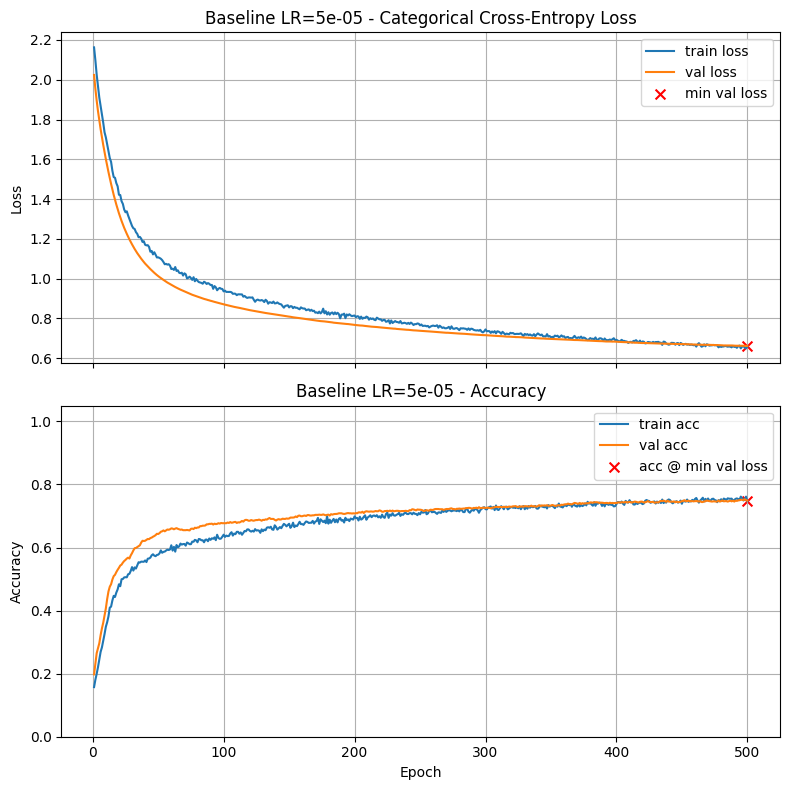

Final Training Loss:            0.6572
Final Training Accuracy:        0.7469
Final Validation Loss:          0.6614
Final Validation Accuracy:      0.7486
Minimum Validation Loss:        0.6614 (Epoch 500)
Validation Accuracy @ Min Loss: 0.7486

Test Loss: 0.6686
Test Accuracy: 0.7436

Validation-Test Gap (accuracy): 0.005000

Execution Time: 00:02:38



Training with learning rate: 1e-05

Baseline LR=1e-05



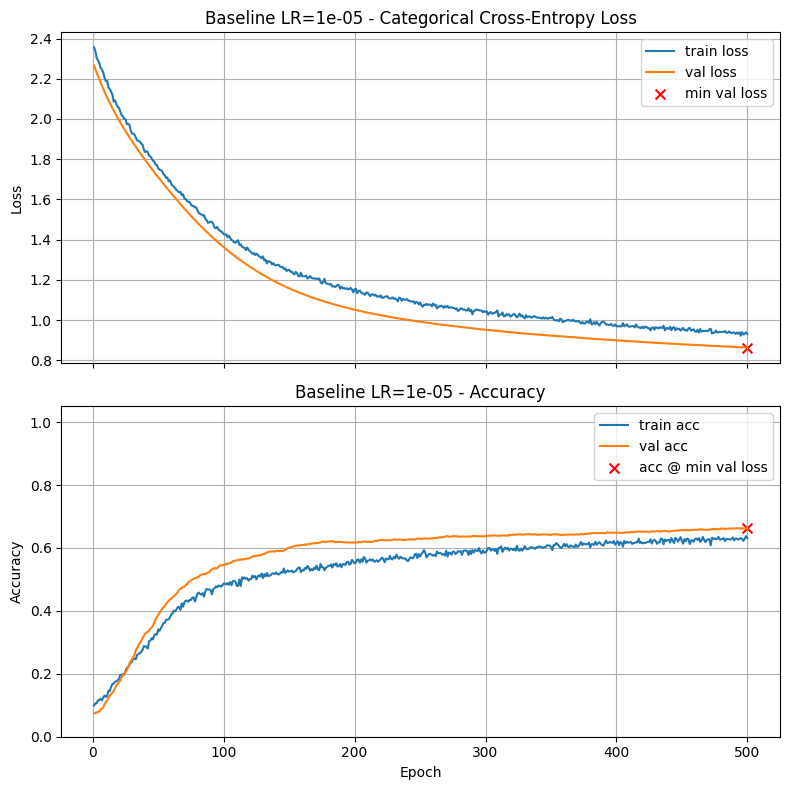

Final Training Loss:            0.9308
Final Training Accuracy:        0.6314
Final Validation Loss:          0.8626
Final Validation Accuracy:      0.6621
Minimum Validation Loss:        0.8626 (Epoch 500)
Validation Accuracy @ Min Loss: 0.6621

Test Loss: 0.8738
Test Accuracy: 0.6714

Validation-Test Gap (accuracy): 0.009286

Execution Time: 00:02:36



 Learning Rate Comparison:
Baseline with relu                      	0.7886
Baseline LR=0.001                       	0.7814
Baseline LR=0.0005                      	0.7707
Baseline LR=0.0001                      	0.7679
Baseline with tanh                      	0.7593
Baseline LR=5e-05                       	0.7486
Baseline with sigmoid                   	0.7386
Baseline LR=1e-05                       	0.6621


In [93]:
# Your code here. Add as many cells as you need.

def build_model_baseline():
    return build_model(
        n_inputs=X_train.shape[1],
        layer_list=[
            (64, "relu", 0.0, 0.0),
            (32, "relu", 0.001, 0.3),
        ],
        n_classes=n_classes
    )

learning_rates = [1e-3, 5e-4, 1e-4, 5e-5, 1e-5]

for lr in learning_rates:
    print(f"\nTraining with learning rate: {lr}")

    model_baseline = build_model_baseline()

    history = train_and_test(
        model_baseline,
        title=f"Baseline LR={lr}",
        epochs=500,
        batch_size=64,
        lr_schedule=lr,
        optimizer="Adam",
        patience=10,
        min_delta=0.0001,
        verbose=0,
        return_history=True
    )

    print("\n" + "="*60 + "\n")

print("\n Learning Rate Comparison:")
print_results()



#### Graded Questions

In [94]:
# Set a2a to the learning rate which provided the best validation accuracy at the epoch of minimum validation loss

a2a = 0.001           # Replace 0.0 with your answer

In [95]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a2a = {a2a:.6f}')

a2a = 0.001000


In [96]:
# Set a2b to the validation accuracy found by this best learning rate

a2b = 0.7814             # Replace 0.0 with your answer

In [97]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a2b = {a2b:.4f}')

a2b = 0.7814


### Problem Three: Dropout

In this problem, you will explore how **dropout** can help prevent overfitting in neural networks. There are no absolute rules, but some useful hueristics are:

* Dropout typically works best in **later dense layers** (e.g., the second hidden layer of width 32) in the range **0.3–0.5**.
* If applied to **earlier layers** (e.g., the first hidden layer), dropout should be smaller, typically **0.0–0.2** (where 0.0 means no dropout).

**Steps to follow:**

* Build and train the **baseline model** using the **activation function from Problem One** and the **learning rate from Problem Two**.
* Investigate dropout in the ranges suggested, using increments of **0.1**.
* Identify which dropout configuration produces the **best validation accuracy** at the epoch of **minimum validation loss**.
* Answer the graded questions.



Training: Dropout d1=0.0, d2=0.3

Dropout d1=0.0, d2=0.3



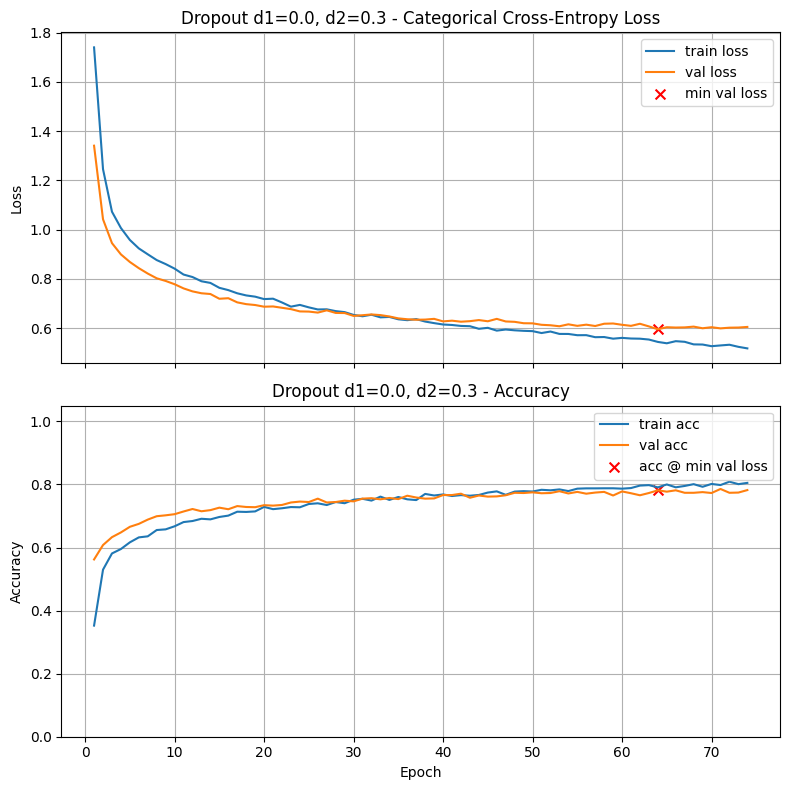

Final Training Loss:            0.5178
Final Training Accuracy:        0.8050
Final Validation Loss:          0.6049
Final Validation Accuracy:      0.7821
Minimum Validation Loss:        0.5955 (Epoch 64)
Validation Accuracy @ Min Loss: 0.7814

Test Loss: 0.6102
Test Accuracy: 0.7679

Validation-Test Gap (accuracy): 0.013571

Execution Time: 00:00:25



Training: Dropout d1=0.0, d2=0.4

Dropout d1=0.0, d2=0.4



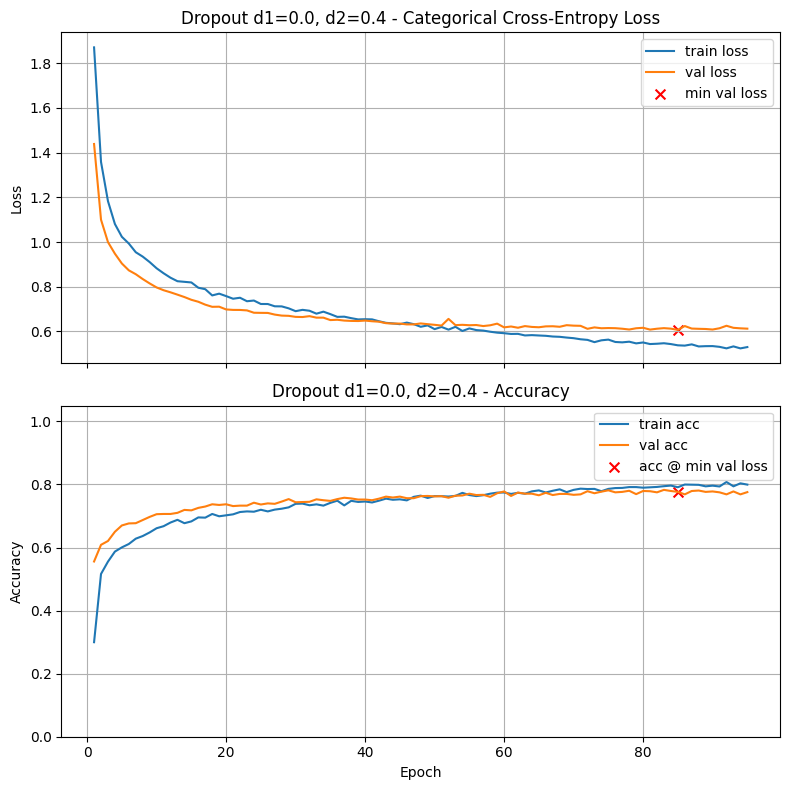

Final Training Loss:            0.5301
Final Training Accuracy:        0.7995
Final Validation Loss:          0.6124
Final Validation Accuracy:      0.7757
Minimum Validation Loss:        0.6071 (Epoch 85)
Validation Accuracy @ Min Loss: 0.7764

Test Loss: 0.6279
Test Accuracy: 0.7664

Validation-Test Gap (accuracy): 0.010000

Execution Time: 00:00:30



Training: Dropout d1=0.0, d2=0.5

Dropout d1=0.0, d2=0.5



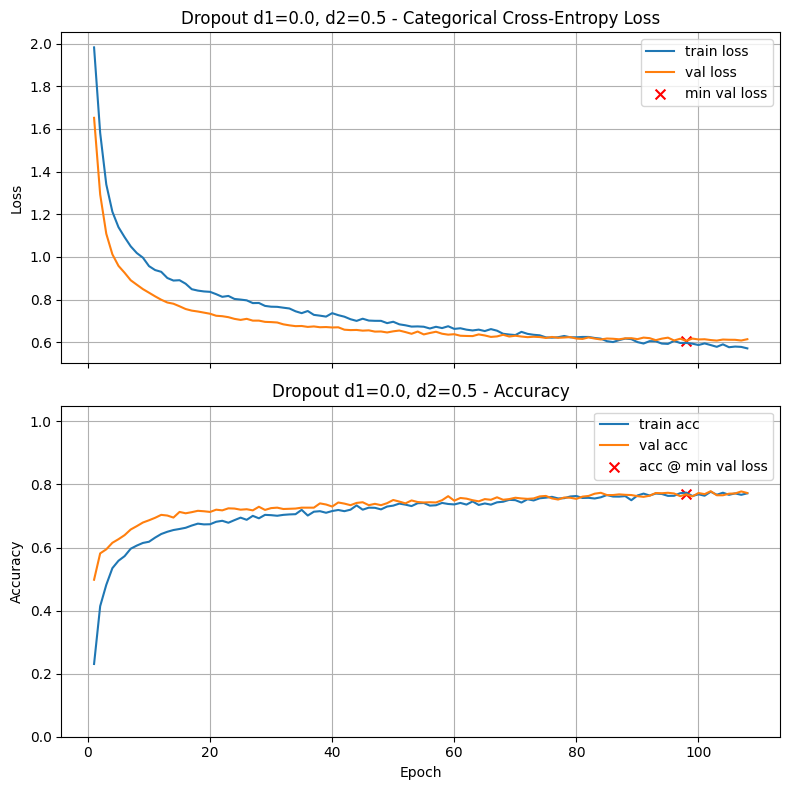

Final Training Loss:            0.5713
Final Training Accuracy:        0.7719
Final Validation Loss:          0.6143
Final Validation Accuracy:      0.7729
Minimum Validation Loss:        0.6067 (Epoch 98)
Validation Accuracy @ Min Loss: 0.7686

Test Loss: 0.6415
Test Accuracy: 0.7557

Validation-Test Gap (accuracy): 0.012857

Execution Time: 00:00:34



Training: Dropout d1=0.1, d2=0.3

Dropout d1=0.1, d2=0.3



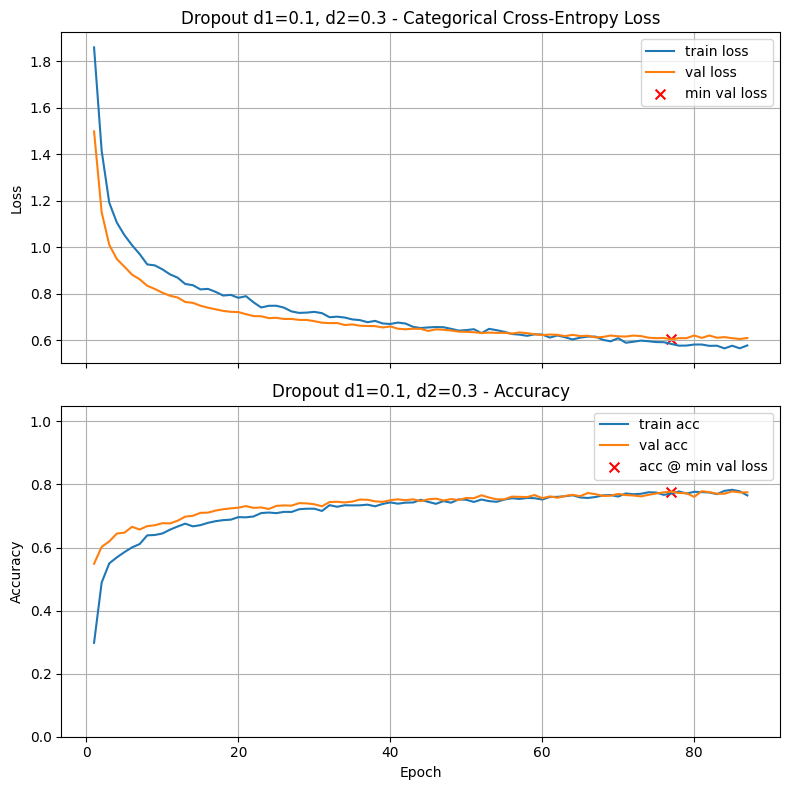

Final Training Loss:            0.5785
Final Training Accuracy:        0.7652
Final Validation Loss:          0.6105
Final Validation Accuracy:      0.7750
Minimum Validation Loss:        0.6048 (Epoch 77)
Validation Accuracy @ Min Loss: 0.7771

Test Loss: 0.6217
Test Accuracy: 0.7707

Validation-Test Gap (accuracy): 0.006429

Execution Time: 00:00:30



Training: Dropout d1=0.1, d2=0.4

Dropout d1=0.1, d2=0.4



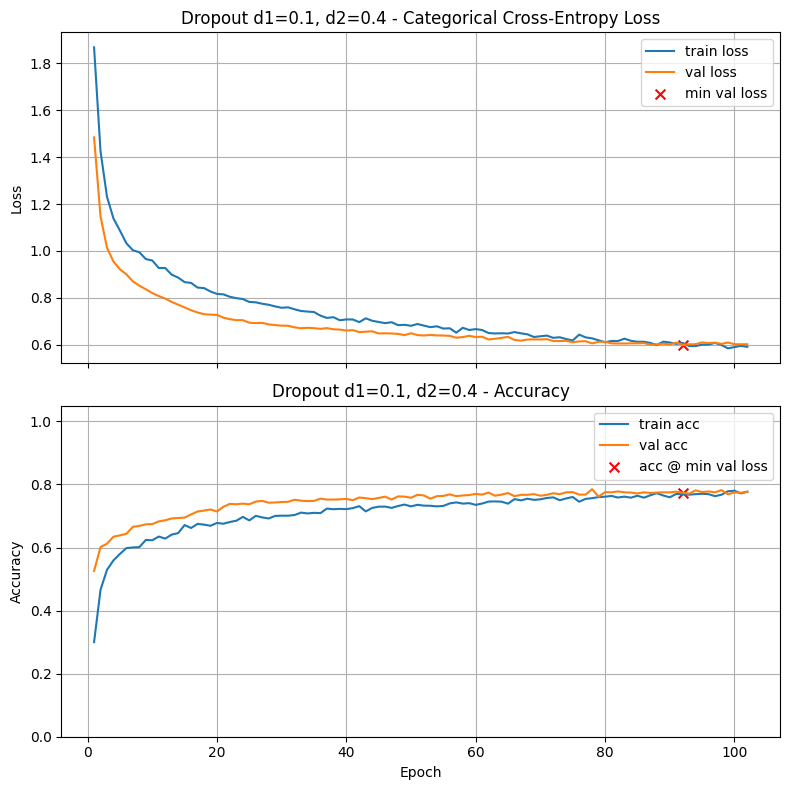

Final Training Loss:            0.5910
Final Training Accuracy:        0.7771
Final Validation Loss:          0.6020
Final Validation Accuracy:      0.7764
Minimum Validation Loss:        0.6003 (Epoch 92)
Validation Accuracy @ Min Loss: 0.7736

Test Loss: 0.6282
Test Accuracy: 0.7429

Validation-Test Gap (accuracy): 0.030714

Execution Time: 00:00:33



Training: Dropout d1=0.1, d2=0.5

Dropout d1=0.1, d2=0.5



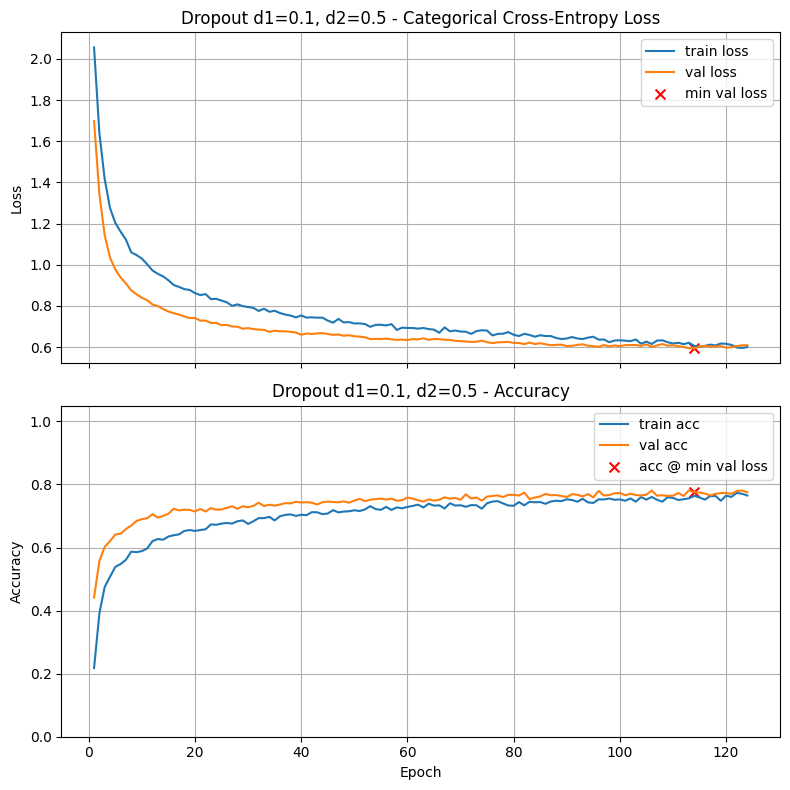

Final Training Loss:            0.6001
Final Training Accuracy:        0.7650
Final Validation Loss:          0.6094
Final Validation Accuracy:      0.7750
Minimum Validation Loss:        0.5939 (Epoch 114)
Validation Accuracy @ Min Loss: 0.7750

Test Loss: 0.6266
Test Accuracy: 0.7507

Validation-Test Gap (accuracy): 0.024286

Execution Time: 00:00:40



Training: Dropout d1=0.2, d2=0.3

Dropout d1=0.2, d2=0.3



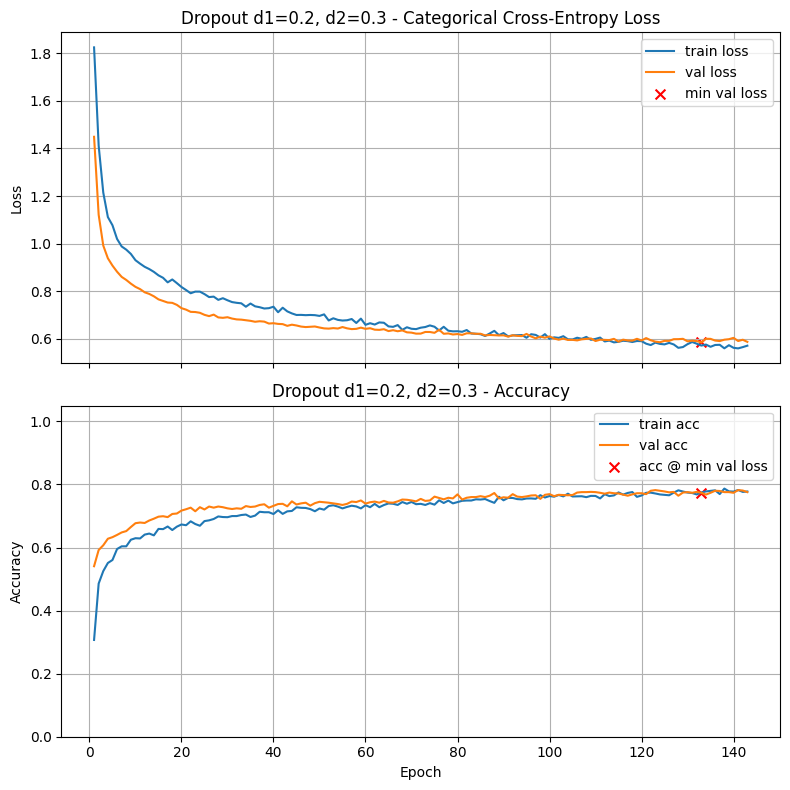

Final Training Loss:            0.5706
Final Training Accuracy:        0.7776
Final Validation Loss:          0.5867
Final Validation Accuracy:      0.7757
Minimum Validation Loss:        0.5841 (Epoch 133)
Validation Accuracy @ Min Loss: 0.7736

Test Loss: 0.6189
Test Accuracy: 0.7629

Validation-Test Gap (accuracy): 0.010714

Execution Time: 00:00:45



Training: Dropout d1=0.2, d2=0.4

Dropout d1=0.2, d2=0.4



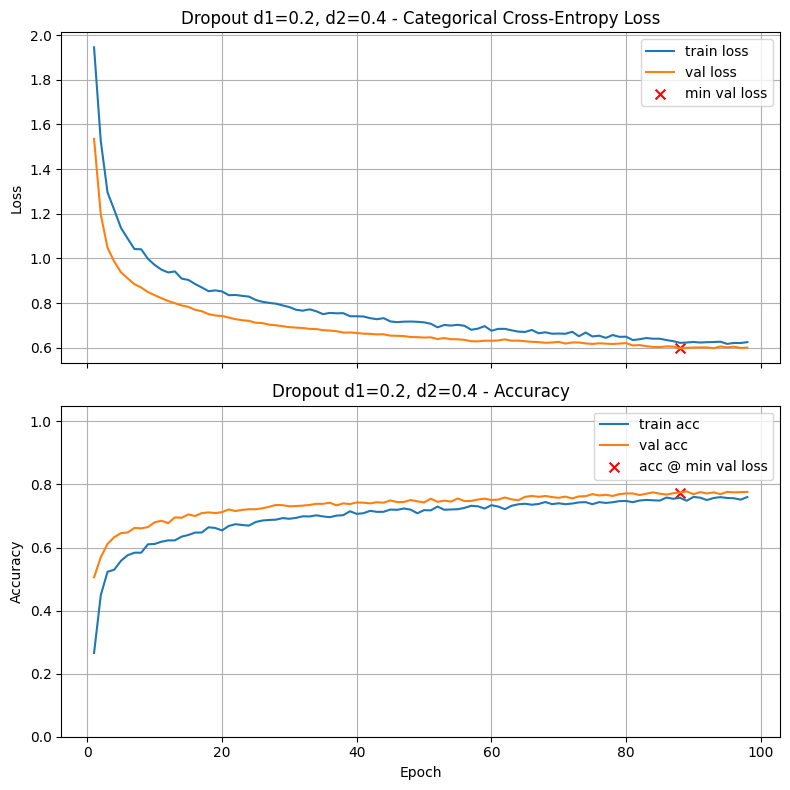

Final Training Loss:            0.6253
Final Training Accuracy:        0.7600
Final Validation Loss:          0.6009
Final Validation Accuracy:      0.7764
Minimum Validation Loss:        0.5972 (Epoch 88)
Validation Accuracy @ Min Loss: 0.7743

Test Loss: 0.6254
Test Accuracy: 0.7636

Validation-Test Gap (accuracy): 0.010714

Execution Time: 00:00:31



Training: Dropout d1=0.2, d2=0.5

Dropout d1=0.2, d2=0.5



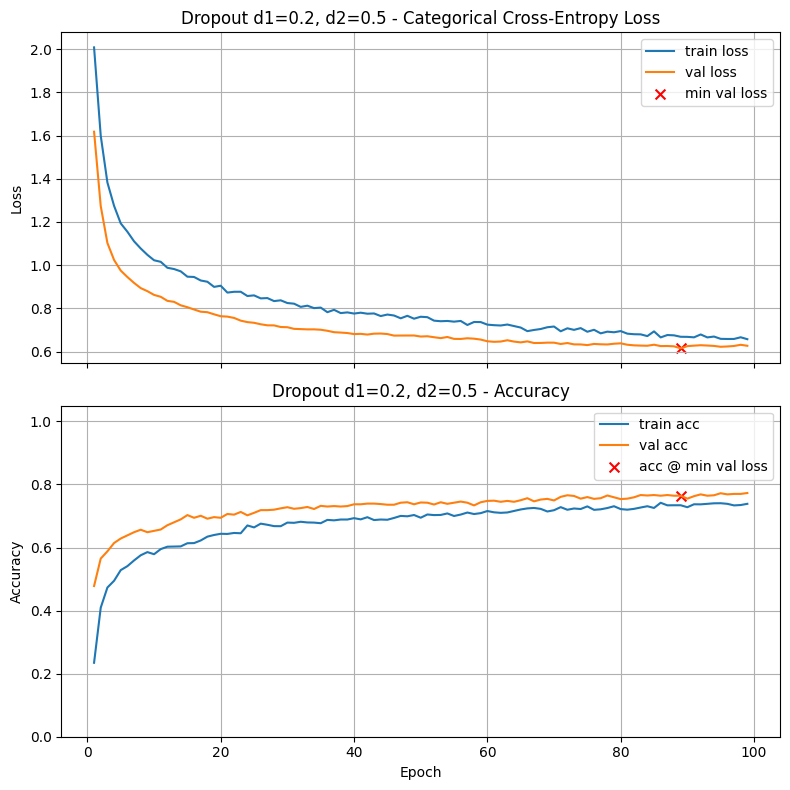

Final Training Loss:            0.6570
Final Training Accuracy:        0.7386
Final Validation Loss:          0.6265
Final Validation Accuracy:      0.7729
Minimum Validation Loss:        0.6145 (Epoch 89)
Validation Accuracy @ Min Loss: 0.7643

Test Loss: 0.6601
Test Accuracy: 0.7400

Validation-Test Gap (accuracy): 0.024286

Execution Time: 00:00:33



 Dropout Configuration Comparison:
Baseline with relu                      	0.7886
Baseline LR=0.001                       	0.7814
Dropout d1=0.0, d2=0.3                  	0.7814
Dropout d1=0.1, d2=0.3                  	0.7771
Dropout d1=0.0, d2=0.4                  	0.7764
Dropout d1=0.1, d2=0.5                  	0.7750
Dropout d1=0.2, d2=0.4                  	0.7743
Dropout d1=0.1, d2=0.4                  	0.7736
Dropout d1=0.2, d2=0.3                  	0.7736
Baseline LR=0.0005                      	0.7707
Dropout d1=0.0, d2=0.5                  	0.7686
Baseline LR=0.0001                      	0.7679
Dropout d1=0.2, d2=0.5          

In [98]:
# Your code here. Add as many cells as you need.
dropout_first = [0.0, 0.1, 0.2]
dropout_second = [0.3, 0.4, 0.5]

def build_model_dropout(d1, d2):
    return build_model(
        n_inputs=X_train.shape[1],
        layer_list=[
            (64, "relu", 0.0, d1),
            (32, "relu", 0.001, d2),
        ],
        n_classes=n_classes
    )

for d1 in dropout_first:
    for d2 in dropout_second:
        title = f"Dropout d1={d1}, d2={d2}"
        print(f"\nTraining: {title}")

        model = build_model_dropout(d1, d2)

        history = train_and_test(
            model,
            title=title,
            epochs=500,
            batch_size=64,
            lr_schedule=0.001,
            optimizer="Adam",
            patience=10,
            min_delta=0.0001,
            verbose=0,
            return_history=True
        )

        print("\n" + "="*60 + "\n")


print("\n Dropout Configuration Comparison:")
print_results()



In [117]:
# Set a3a to the pair (dropout_rate_64,dropout_rate_32) of dropout rates for the two hidden layers which provided the best
# validation accuracy at the epoch of minimum validation loss

a3a = (0.0,0.3)             # Replace (0.0,0.0) with your answer

In [118]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a3a = {a3a}')

a3a = (0.0, 0.3)


In [119]:
# Set a3b to the validation accuracy found by this best pair of dropout rates

a3b = 0.7814             # Replace 0.0 with your answer

In [120]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a3b = {a3b:.4f}')

a3b = 0.7814


### Problem Four: L2 Regularization

In this problem, you will explore how **L2 regularization** (also called *weight decay*) can help prevent overfitting in neural networks. There are no absolute rules, but some useful heuristics are:

* Start simple by using the **same λ in both hidden layers**, with values:

  ```
      1e-4, 1e-3, 1e-2
  ```

* If validation results suggest underfitting in the first layer or persistent overfitting in the later one, then try adjusting per layer, for example:

  * First hidden layer: λ = 1e-4
  * Second hidden layer: λ = 1e-3

**Steps to follow:**

* Build and train the **baseline model** using the **activation function from Problem One** and the **learning rate from Problem Two**, but **without dropout**.
* Investigate at least the four cases suggested (three with the same λ and one with different λ values). You may also consider additional combinations.
* Identify which configuration produces the **best validation accuracy** at the epoch of **minimum validation loss**.
* Answer the graded questions.



Training: L2 λ1=0.0001, λ2=0.0001

L2 λ1=0.0001, λ2=0.0001



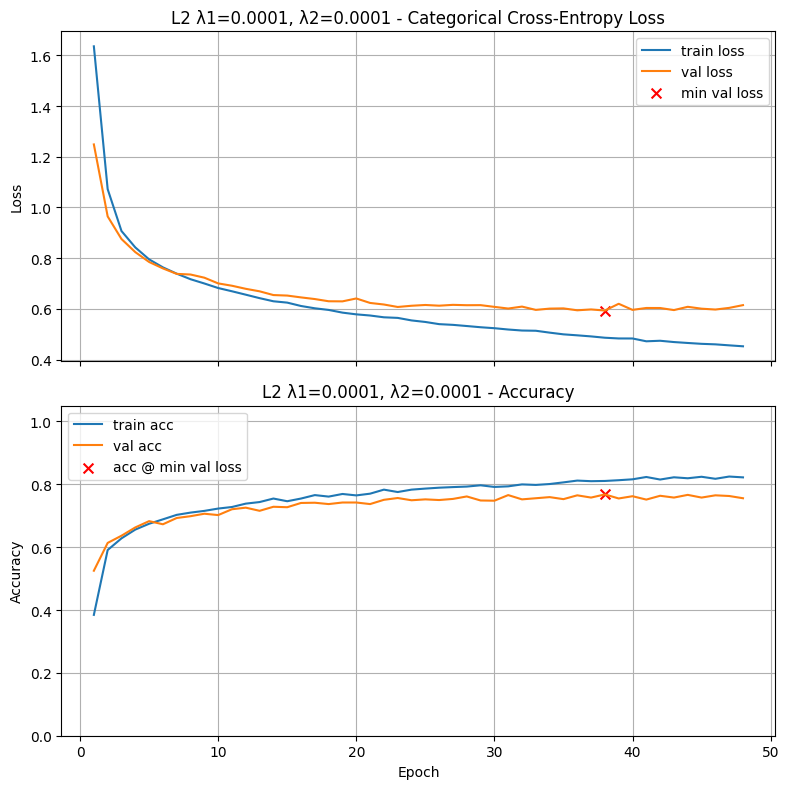

Final Training Loss:            0.4528
Final Training Accuracy:        0.8221
Final Validation Loss:          0.6151
Final Validation Accuracy:      0.7557
Minimum Validation Loss:        0.5938 (Epoch 38)
Validation Accuracy @ Min Loss: 0.7679

Test Loss: 0.6087
Test Accuracy: 0.7550

Validation-Test Gap (accuracy): 0.012857

Execution Time: 00:00:17



Training: L2 λ1=0.001, λ2=0.001

L2 λ1=0.001, λ2=0.001



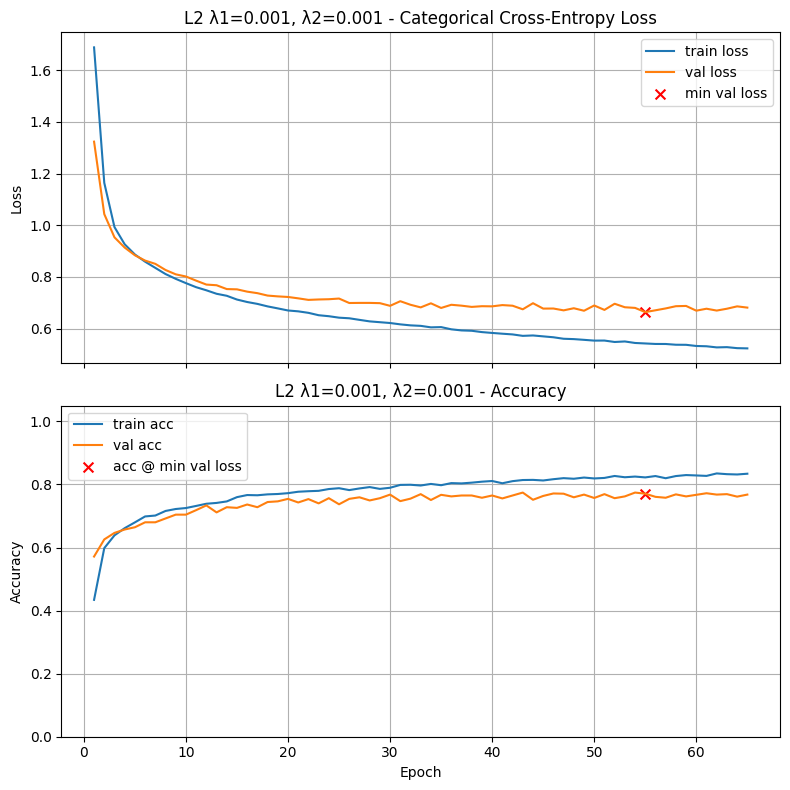

Final Training Loss:            0.5234
Final Training Accuracy:        0.8340
Final Validation Loss:          0.6812
Final Validation Accuracy:      0.7679
Minimum Validation Loss:        0.6639 (Epoch 55)
Validation Accuracy @ Min Loss: 0.7707

Test Loss: 0.6790
Test Accuracy: 0.7564

Validation-Test Gap (accuracy): 0.014286

Execution Time: 00:00:21



Training: L2 λ1=0.01, λ2=0.01

L2 λ1=0.01, λ2=0.01



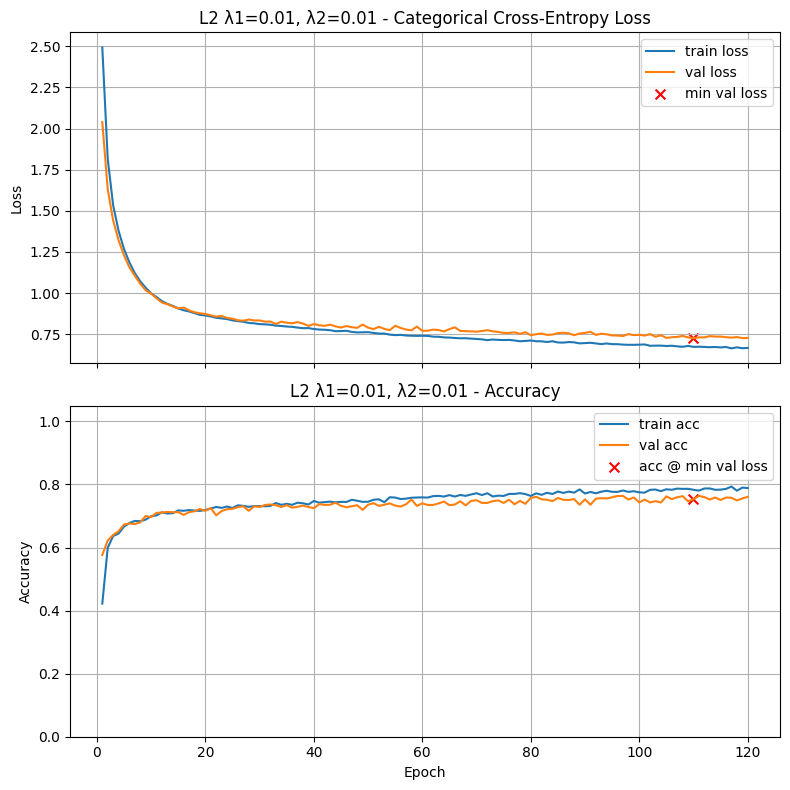

Final Training Loss:            0.6671
Final Training Accuracy:        0.7886
Final Validation Loss:          0.7279
Final Validation Accuracy:      0.7607
Minimum Validation Loss:        0.7260 (Epoch 110)
Validation Accuracy @ Min Loss: 0.7536

Test Loss: 0.7522
Test Accuracy: 0.7464

Validation-Test Gap (accuracy): 0.007143

Execution Time: 00:00:38



Training: L2 λ1=0.0001, λ2=0.001

L2 λ1=0.0001, λ2=0.001



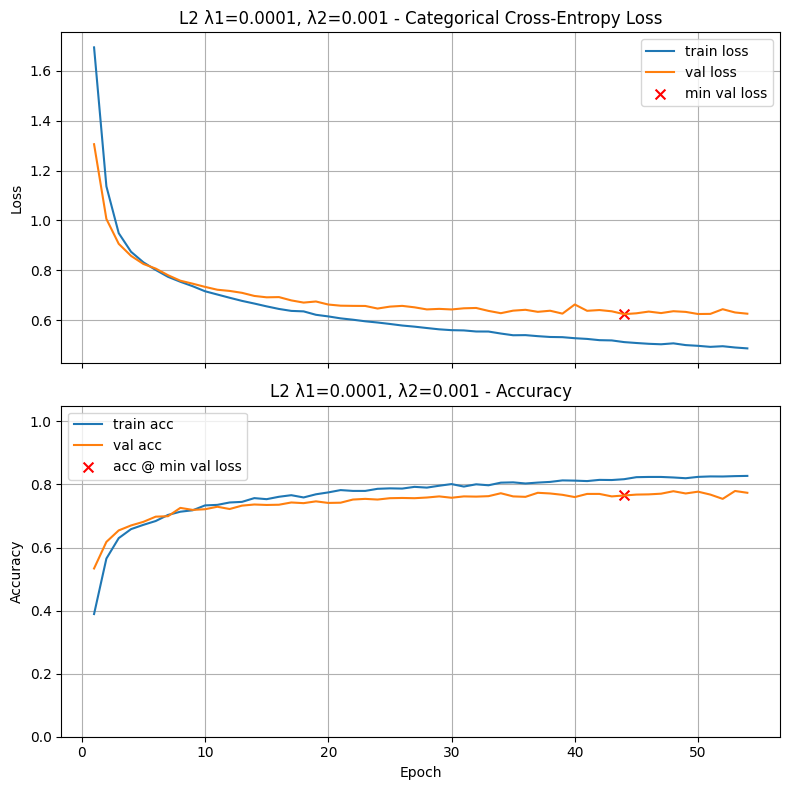

Final Training Loss:            0.4878
Final Training Accuracy:        0.8271
Final Validation Loss:          0.6267
Final Validation Accuracy:      0.7736
Minimum Validation Loss:        0.6248 (Epoch 44)
Validation Accuracy @ Min Loss: 0.7650

Test Loss: 0.6552
Test Accuracy: 0.7614

Validation-Test Gap (accuracy): 0.003571

Execution Time: 00:00:19



 L2 Regularization Comparison:
Baseline with relu                      	0.7886
Baseline LR=0.001                       	0.7814
Dropout d1=0.0, d2=0.3                  	0.7814
Dropout d1=0.1, d2=0.3                  	0.7771
Dropout d1=0.0, d2=0.4                  	0.7764
Dropout d1=0.1, d2=0.5                  	0.7750
Dropout d1=0.2, d2=0.4                  	0.7743
Dropout d1=0.1, d2=0.4                  	0.7736
Dropout d1=0.2, d2=0.3                  	0.7736
Baseline LR=0.0005                      	0.7707
L2 λ1=0.001, λ2=0.001                   	0.7707
Dropout d1=0.0, d2=0.5                  	0.7686
Baseline LR=0.0001                  

In [103]:
# Your code here. Add as many cells as you need.
l2_configs = [
    (1e-4, 1e-4),
    (1e-3, 1e-3),
    (1e-2, 1e-2),
    (1e-4, 1e-3),
]

def build_model_l2(l2_1, l2_2):
    return build_model(
        n_inputs=X_train.shape[1],
        layer_list=[
            (64, "relu", l2_1, 0.0),
            (32, "relu", l2_2, 0.0),
        ],
        n_classes=n_classes
    )

for l2_1, l2_2 in l2_configs:
    title = f"L2 λ1={l2_1}, λ2={l2_2}"
    print(f"\nTraining: {title}")

    model = build_model_l2(l2_1, l2_2)

    history = train_and_test(
        model,
        title=title,
        epochs=500,
        batch_size=64,
        lr_schedule=0.001,
        optimizer="Adam",
        patience=10,
        min_delta=0.0001,
        verbose=0,
        return_history=True
    )

    print("\n" + "="*60 + "\n")

print("\n L2 Regularization Comparison:")
print_results()



In [121]:
# Set a4a to the pair (L2_lambda_64,L2_lambda_32) of the L2 lambdas for the two hidden layers which provided the best
# validation accuracy at the epoch of minimum validation loss

a4a = (0.001, 0.001)             # Replace (0.0,0.0) with your answer

In [122]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a4a = {a4a}')

a4a = (0.001, 0.001)


In [123]:
# Set a4b to the validation accuracy found by this best pair of lambdas

a4b = 0.7707             # Replace 0.0 with your answer

In [124]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a4b = {a4b:.4f}')

a4b = 0.7707


### Problem Five: Combining Dropout with L2 Regularization

In this problem, you will explore how **dropout** and **L2 regularization** can work together to prevent overfitting. These two methods complement each other, but must be balanced carefully. A useful rule of thumb is:

* If dropout is **high**, use a **smaller λ**.
* If dropout is **low**, you can afford a **larger λ**.

**Steps to follow:**

* Build and train the **baseline model** using the **activation function from Problem One** and the **learning rate from Problem Two**.
* Investigate combinations of dropout and L2:

  * First, use the **dropout rate you identified in Problem Three** as a baseline.
  * Then, add L2 to both hidden layers with values:

    ```
        1e-4, 1e-3, 1e-2
    ```

    while keeping dropout fixed.
  * Finally, try **reducing dropout slightly** when L2 is added to see if performance improves.
  * [Optional] You may wish to investigate other combinations not covered here; for example, promising but not optimal choices of dropout rates may provide overall better performance when combines with L2 Regulari
* Identify which combination produces the **best validation accuracy** at the epoch of **minimum validation loss**.
* Answer the graded questions.




Training: Dropout (0.0, 0.4) + L2 (0.0001, 0.0001)

Dropout (0.0, 0.4) + L2 (0.0001, 0.0001)



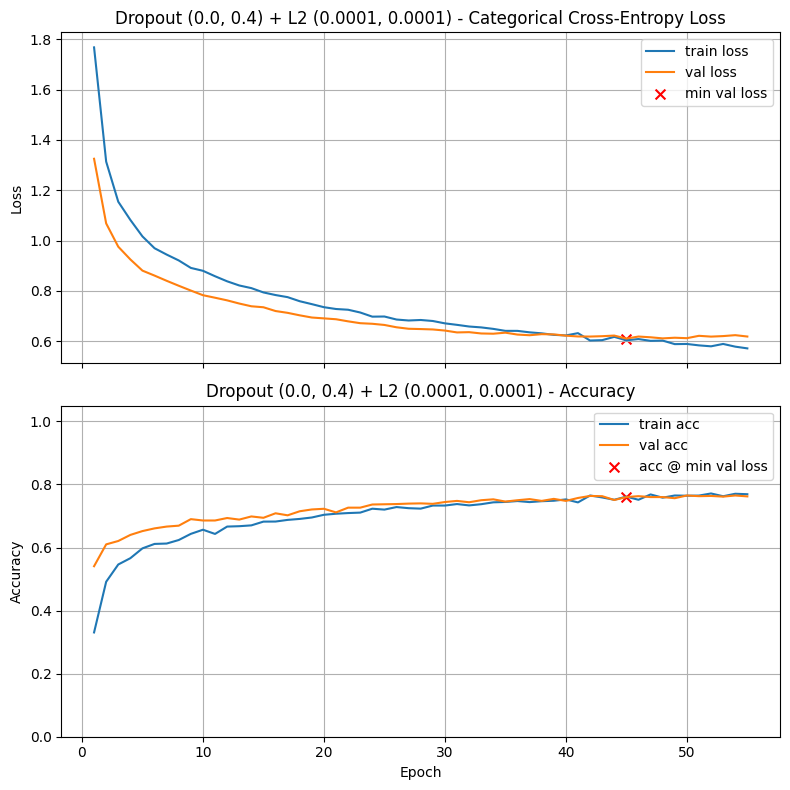

Final Training Loss:            0.5720
Final Training Accuracy:        0.7690
Final Validation Loss:          0.6191
Final Validation Accuracy:      0.7621
Minimum Validation Loss:        0.6109 (Epoch 45)
Validation Accuracy @ Min Loss: 0.7600

Test Loss: 0.6302
Test Accuracy: 0.7343

Validation-Test Gap (accuracy): 0.025714

Execution Time: 00:00:20



Training: Dropout (0.0, 0.4) + L2 (0.001, 0.001)

Dropout (0.0, 0.4) + L2 (0.001, 0.001)



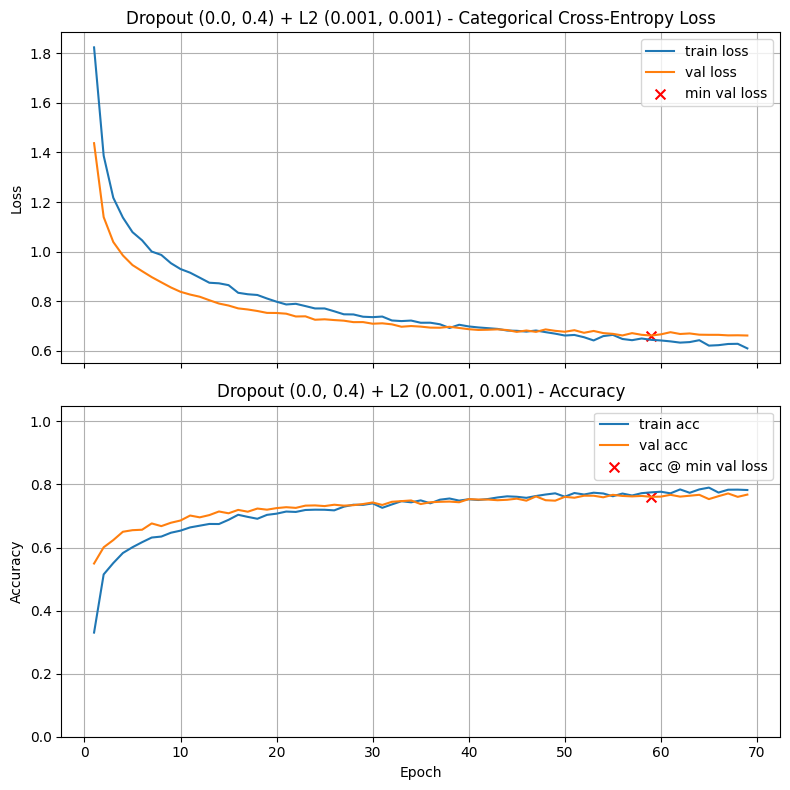

Final Training Loss:            0.6094
Final Training Accuracy:        0.7824
Final Validation Loss:          0.6613
Final Validation Accuracy:      0.7679
Minimum Validation Loss:        0.6612 (Epoch 59)
Validation Accuracy @ Min Loss: 0.7607

Test Loss: 0.6883
Test Accuracy: 0.7529

Validation-Test Gap (accuracy): 0.007857

Execution Time: 00:00:23



Training: Dropout (0.0, 0.4) + L2 (0.01, 0.01)

Dropout (0.0, 0.4) + L2 (0.01, 0.01)



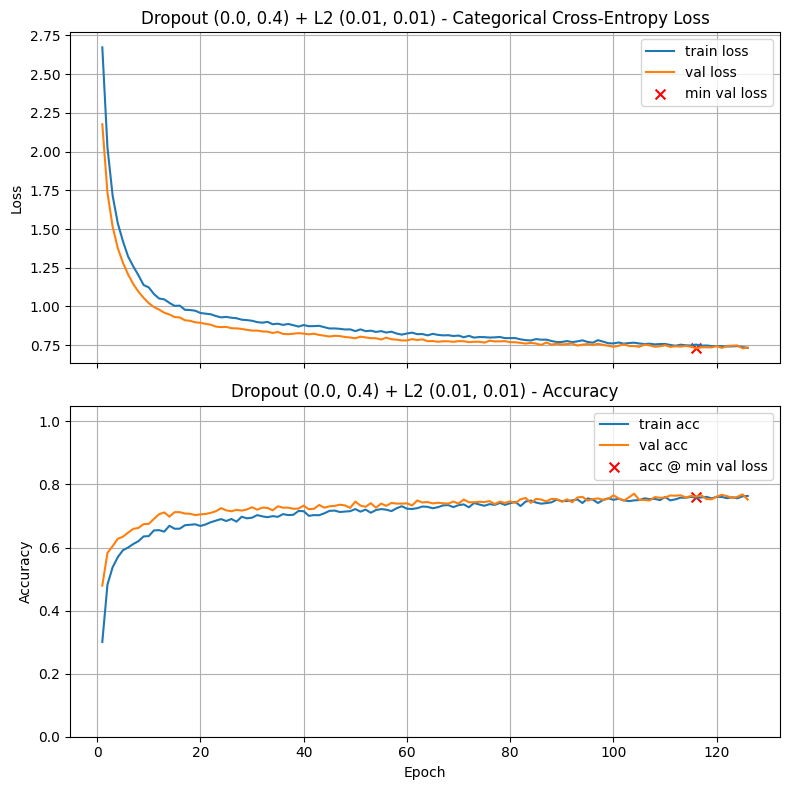

Final Training Loss:            0.7325
Final Training Accuracy:        0.7636
Final Validation Loss:          0.7338
Final Validation Accuracy:      0.7521
Minimum Validation Loss:        0.7290 (Epoch 116)
Validation Accuracy @ Min Loss: 0.7614

Test Loss: 0.7504
Test Accuracy: 0.7507

Validation-Test Gap (accuracy): 0.010714

Execution Time: 00:00:40



Training: Dropout (0.0, 0.3) + L2 (1e-3, 1e-3)

Dropout (0.0, 0.3) + L2 (1e-3, 1e-3)



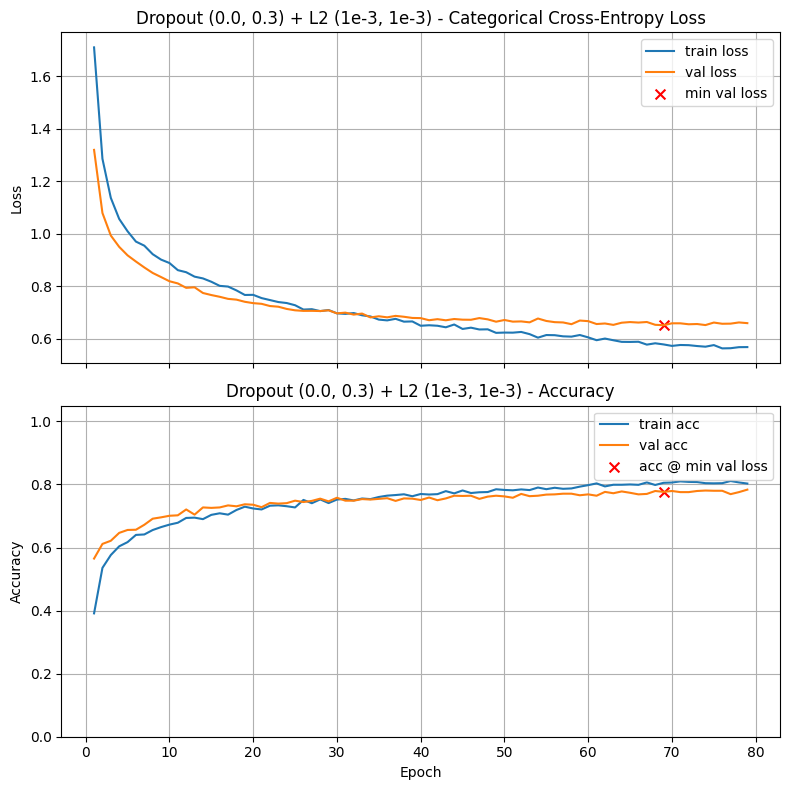

Final Training Loss:            0.5692
Final Training Accuracy:        0.8029
Final Validation Loss:          0.6603
Final Validation Accuracy:      0.7836
Minimum Validation Loss:        0.6523 (Epoch 69)
Validation Accuracy @ Min Loss: 0.7764

Test Loss: 0.6672
Test Accuracy: 0.7693

Validation-Test Gap (accuracy): 0.007143

Execution Time: 00:00:26



Training: Dropout (0.1, 0.3) + L2 (1e-3, 1e-3)

Dropout (0.1, 0.3) + L2 (1e-3, 1e-3)



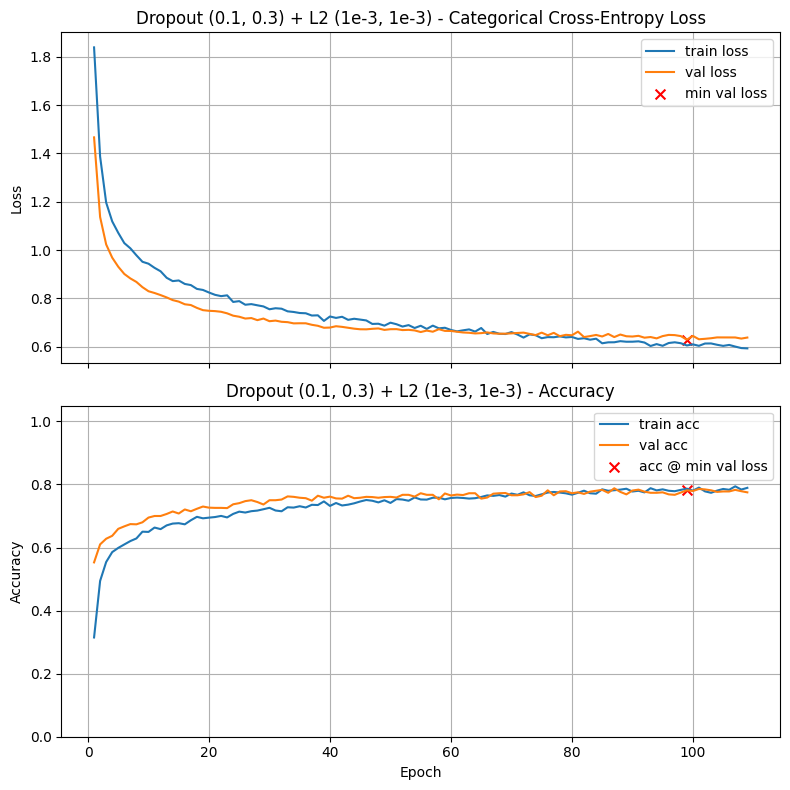

Final Training Loss:            0.5935
Final Training Accuracy:        0.7893
Final Validation Loss:          0.6383
Final Validation Accuracy:      0.7750
Minimum Validation Loss:        0.6295 (Epoch 99)
Validation Accuracy @ Min Loss: 0.7814

Test Loss: 0.6599
Test Accuracy: 0.7579

Validation-Test Gap (accuracy): 0.023571

Execution Time: 00:00:35



Training: Dropout (0.1, 0.4) + L2 (1e-3, 1e-3)

Dropout (0.1, 0.4) + L2 (1e-3, 1e-3)



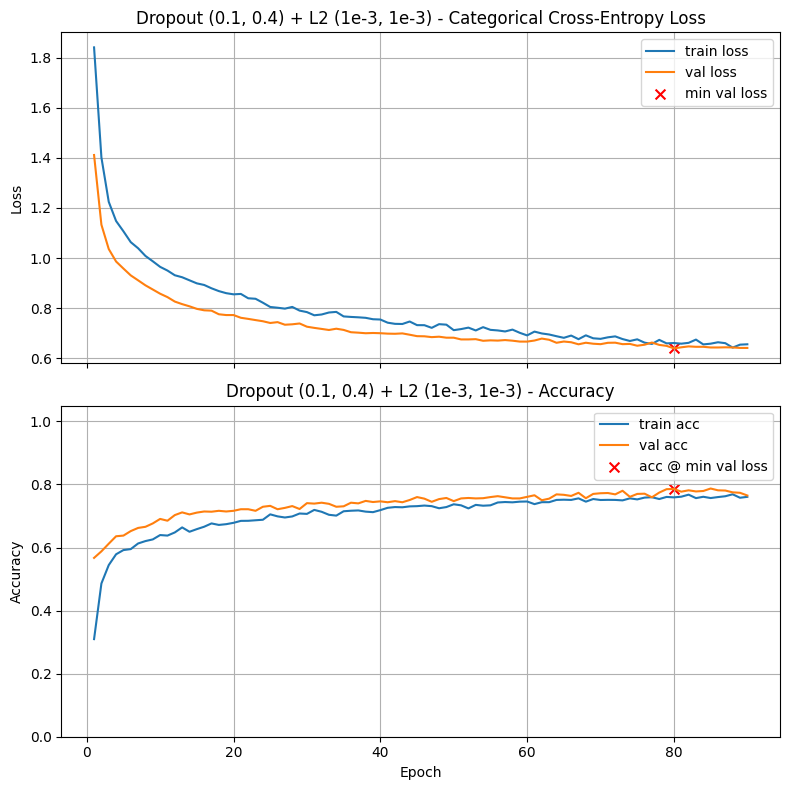

Final Training Loss:            0.6558
Final Training Accuracy:        0.7607
Final Validation Loss:          0.6413
Final Validation Accuracy:      0.7650
Minimum Validation Loss:        0.6395 (Epoch 80)
Validation Accuracy @ Min Loss: 0.7857

Test Loss: 0.6859
Test Accuracy: 0.7593

Validation-Test Gap (accuracy): 0.026429

Execution Time: 00:00:31



 Dropout + L2 Regularization Comparison:
Baseline with relu                      	0.7886
Dropout (0.1, 0.4) + L2 (1e-3, 1e-3)    	0.7857
Baseline LR=0.001                       	0.7814
Dropout d1=0.0, d2=0.3                  	0.7814
Dropout (0.1, 0.3) + L2 (1e-3, 1e-3)    	0.7814
Dropout d1=0.1, d2=0.3                  	0.7771
Dropout d1=0.0, d2=0.4                  	0.7764
Dropout (0.0, 0.3) + L2 (1e-3, 1e-3)    	0.7764
Dropout d1=0.1, d2=0.5                  	0.7750
Dropout d1=0.2, d2=0.4                  	0.7743
Dropout d1=0.1, d2=0.4                  	0.7736
Dropout d1=0.2, d2=0.3                  	0.7736
Baseline LR=0.0005        

In [108]:
# Your code here. Add as many cells as you need.
baseline_dropout = (0.0, 0.4)

l2_values = [1e-4, 1e-3, 1e-2]

def build_model_dropout_l2(d1, d2, l2_1, l2_2):
    return build_model(
        n_inputs=X_train.shape[1],
        layer_list=[
            (64, "relu", l2_1, d1),
            (32, "relu", l2_2, d2),
        ],
        n_classes=n_classes
    )

for l2 in l2_values:
    title = f"Dropout (0.0, 0.4) + L2 ({l2}, {l2})"
    print(f"\nTraining: {title}")

    model = build_model_dropout_l2(0.0, 0.4, l2, l2)

    history = train_and_test(
        model,
        title=title,
        epochs=500,
        batch_size=64,
        lr_schedule=0.001,
        optimizer="Adam",
        patience=10,
        min_delta=0.0001,
        verbose=0,
        return_history=True
    )

    print("\n" + "="*60 + "\n")

adjusted_dropouts = [(0.0, 0.3), (0.1, 0.3), (0.1, 0.4)]

for d1, d2 in adjusted_dropouts:
    title = f"Dropout ({d1}, {d2}) + L2 (1e-3, 1e-3)"
    print(f"\nTraining: {title}")

    model = build_model_dropout_l2(d1, d2, 1e-3, 1e-3)

    history = train_and_test(
        model,
        title=title,
        epochs=500,
        batch_size=64,
        lr_schedule=0.001,
        optimizer="Adam",
        patience=10,
        min_delta=0.0001,
        verbose=0,
        return_history=True
    )

    print("\n" + "="*60 + "\n")

print("\n Dropout + L2 Regularization Comparison:")
print_results()


In [125]:
# Set a5 to the validation accuracy found by this best combination of dropout and L2 regularization

a5 = 0.7857             # Replace 0.0 with your answer

In [126]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a5 = {a5:.4f}')

a5 = 0.7857


### Problem Six: Build and Train Your Best Model

In this final problem, you will design and train your **best-performing model** using the techniques explored in the previous problems. You may make your own choices for:

* **Model architecture** (number of layers, widths, etc.)
* **Learning rate**
* **Batch size** (a new hyperparameter not varied in earlier problems)
* **Dropout rates** in both layers
* **L2 λ values** in both layers
* **[Optional but strongly suggested]:** Learning rate scheduling, using either **Exponential Decay** or **Cosine Decay**.

  * For Exponential Decay, typical decay rates are **0.90–0.999**, with **0.95** often a good starting point.

**Steps to follow:**

* Build and train the model according to your design choices.
* Use early stopping as before to evaluate performance at the epoch of **minimum validation loss**.
* Answer the graded question.



Final Best Model

Epoch 1/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.2197 - loss: 2.0328 - val_accuracy: 0.5229 - val_loss: 1.6071
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4298 - loss: 1.6332 - val_accuracy: 0.5871 - val_loss: 1.3183
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5063 - loss: 1.3838 - val_accuracy: 0.6129 - val_loss: 1.1124
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5226 - loss: 1.2515 - val_accuracy: 0.6143 - val_loss: 1.0145
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5694 - loss: 1.1568 - val_accuracy: 0.6364 - val_loss: 0.9625
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5640 - loss: 1.1138 - val_accuracy: 0.6507 - val_loss: 0.9270
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5826 - loss: 1.0611 - val_accuracy: 0.6643 - val_loss: 0.8994
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5921 - loss: 1.0175 - val_

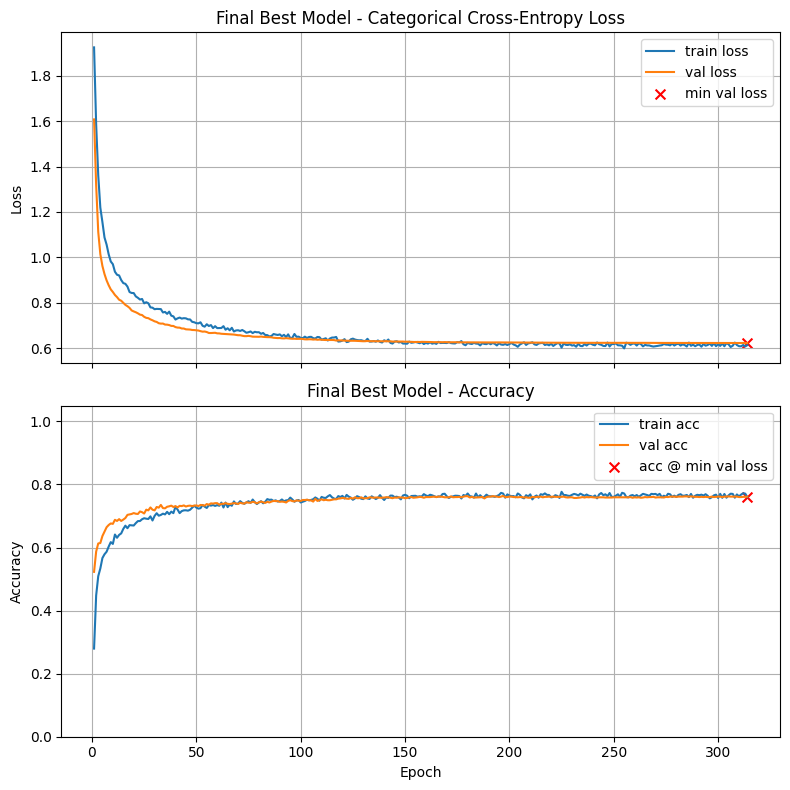

Final Training Loss:            0.6145
Final Training Accuracy:        0.7595
Final Validation Loss:          0.6239
Final Validation Accuracy:      0.7614
Minimum Validation Loss:        0.6239 (Epoch 314)
Validation Accuracy @ Min Loss: 0.7614

Test Loss: 0.6446
Test Accuracy: 0.7557

Validation-Test Gap (accuracy): 0.005000

Execution Time: 00:01:25


In [111]:
# Your code here

from tensorflow.keras.optimizers.schedules import ExponentialDecay

initial_lr = 0.001
decay_rate = 0.95
decay_steps = 100

lr_schedule = ExponentialDecay(
    initial_learning_rate=initial_lr,
    decay_steps=decay_steps,
    decay_rate=decay_rate,
    staircase=True
)

def build_final_model():
    return build_model(
        n_inputs=X_train.shape[1],
        layer_list=[
            (64, "relu", 0.0, 0.0),
            (32, "relu", 0.001, 0.4)
        ],
        n_classes=n_classes
    )

final_model = build_final_model()

history_final = train_and_test(
    final_model,
    title="Final Best Model",
    epochs=500,
    batch_size=128,
    lr_schedule=lr_schedule,
    optimizer="Adam",
    patience=20,
    min_delta=0.0001,
    verbose=1,
    return_history=True
)


In [127]:
# Set a6 to the validation accuracy found by this best model

a6 = 0.7614             # Replace 0.0 with your answer

In [128]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a6 = {a6:.4f}')

a6 = 0.7614


### Optional: Print out your results of all experiments

In [129]:
print_results()

Baseline with relu                      	0.7886
Dropout (0.1, 0.4) + L2 (1e-3, 1e-3)    	0.7857
Baseline LR=0.001                       	0.7814
Dropout d1=0.0, d2=0.3                  	0.7814
Dropout (0.1, 0.3) + L2 (1e-3, 1e-3)    	0.7814
Dropout d1=0.1, d2=0.3                  	0.7771
Dropout d1=0.0, d2=0.4                  	0.7764
Dropout (0.0, 0.3) + L2 (1e-3, 1e-3)    	0.7764
Dropout d1=0.1, d2=0.5                  	0.7750
Dropout d1=0.2, d2=0.4                  	0.7743
Dropout d1=0.1, d2=0.4                  	0.7736
Dropout d1=0.2, d2=0.3                  	0.7736
Baseline LR=0.0005                      	0.7707
L2 λ1=0.001, λ2=0.001                   	0.7707
Dropout d1=0.0, d2=0.5                  	0.7686
Baseline LR=0.0001                      	0.7679
L2 λ1=0.0001, λ2=0.0001                 	0.7679
L2 λ1=0.0001, λ2=0.001                  	0.7650
Dropout d1=0.2, d2=0.5                  	0.7643
Dropout (0.0, 0.4) + L2 (0.01, 0.01)    	0.7614
Final Best Model                        

## Reflection Questions (ungraded)

1. Activation Functions:

    - Why do you think one activation function worked better than the others for this task?
    
    - How might this choice differ for deeper or wider networks?

2. Learning Rate:

    - Would a much smaller learning rate (with many more epochs) likely produce better accuracy?
    
    - When is it worth training longer with a smaller step size, and when is it unnecessary?

3. Dropout vs. L2:

    - Which form of regularization — dropout or L2 — gave better results in your experiments?
    
    - Why might one method be more effective in this setting?

4. Combining Dropout and L2:

    - Why might the combination of dropout and L2 sometimes perform worse than using one method alone?
    
    - What does this tell you about the balance between bias and variance in regularization?

5. Best Model:

    - When you designed your best model, what trade-offs did you notice between model complexity, training stability, and generalization?
    
    - Did learning rate scheduling (if you tried it) improve results? Why might it help?